In [1]:
import torch
import torchvision

batch_size = 1
data_path = 'cifar10_data'
model_path = '../models/LeNet5_cifar10_adv'
to_tensor = torchvision.transforms.PILToTensor()
to_double = torchvision.transforms.ConvertImageDtype(torch.double)
cifar_transform = torchvision.transforms.Compose([to_tensor,
                                                  to_double])
cifar_test_data = torchvision.datasets.CIFAR10(data_path,
                                                transform=cifar_transform,
                                                train=False,
                                                download=True)
test_data = torch.utils.data.DataLoader(cifar_test_data,
                                        batch_size=batch_size,
                                        shuffle=True)

Files already downloaded and verified


In [2]:
from model import LeNet5

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# load model trained for 10,000 iterations (batches)
adv_model = LeNet5(10).double().to(device)
adv_model.load_state_dict(torch.load(model_path + 'final_20_adv.pt', map_location=device))
adv_model.eval()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [5]:
from pgd_attack import LinfPGDAttack
from tqdm import tqdm

img_tensor, label = next(iter(test_data))
img_tensor = img_tensor.to(device)
label = label.to(device)

epsilons = [0.01, 0.05, 0.1, 0.2, 0.5]
num_steps = 20
step_size = 2.0
random_start = True
imgs = [img_tensor.squeeze()]

for eps in tqdm(epsilons):
    adv_attack = LinfPGDAttack(adv_model,
                               eps,
                               num_steps,
                               step_size,
                               random_start,
                               device)
    x = adv_attack.perturb(img_tensor, label)
    imgs.append(x.squeeze())

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.74it/s]


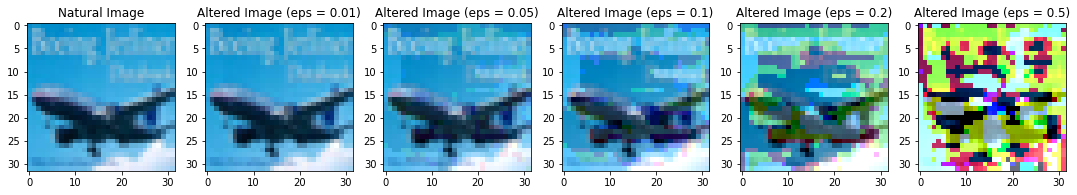

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(epsilons)+1, figsize=(15, 15))
for i in range(len(axes)):
    axes[i].imshow(torch.moveaxis(imgs[i].cpu(), 0, 2))
    if i == 0:
        axes[i].set_title('Natural Image')
    else:
        axes[i].set_title(f'Altered Image (eps = {epsilons[i-1]})')
fig.tight_layout()
plt.savefig('../results/varying_strength.png')
plt.show()